# Lets build a full translation model using a full transformer encoder and decoder

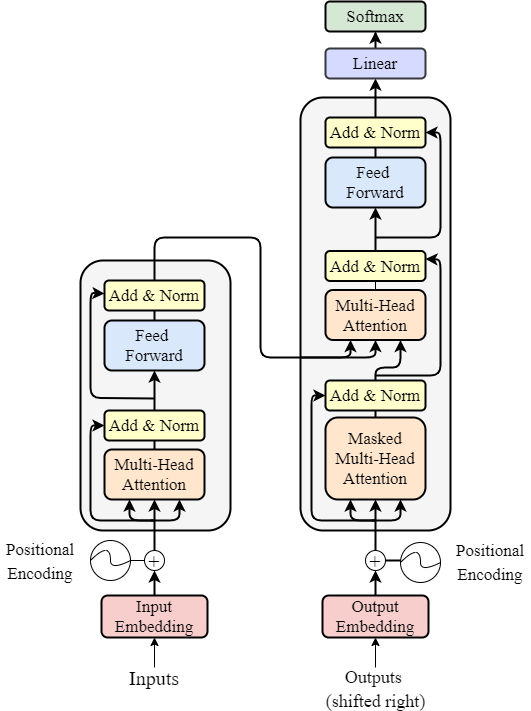

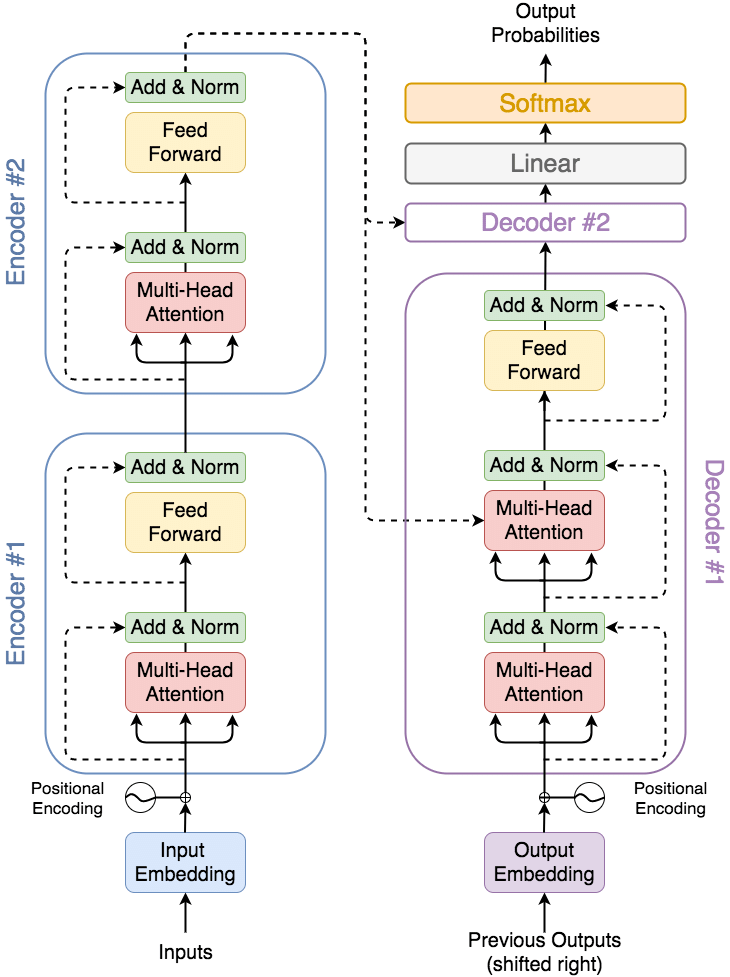

We will build the transformer model using the following steps:
1. Input Embedding
2. Positional Encoding
3. Encoder
4. Decoder
5. Output Layer
6. Transformer

References: 

https://www.youtube.com/watch?v=ISNdQcPhsts&ab_channel=UmarJamil
Attention is all you need paper: https://arxiv.org/abs/1706.03762



In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First step is to build the Input Embedding

The InputEmbedding class implements an embedding layer that transforms discrete input tokens into continuous vector representations. The class is initialized with two parameters:

* embed_dim: This represents the dimensionality of the output embeddings. It defines the size of the continuous vector space in which the input tokens are embedded.

* vocab_size: This denotes the total number of unique tokens in the input vocabulary.

The self.embedding layer within the InputEmbedding class is indeed learned during the training process. When the forward method is called, it first embeds the input tensor using this embedding layer. The embeddings generated by this layer are learnable parameters, which means their values are adjusted during the training process to minimize a defined loss function.

    The output when used will be a tensor of shape (batch_size, seq_len, embed_dim).

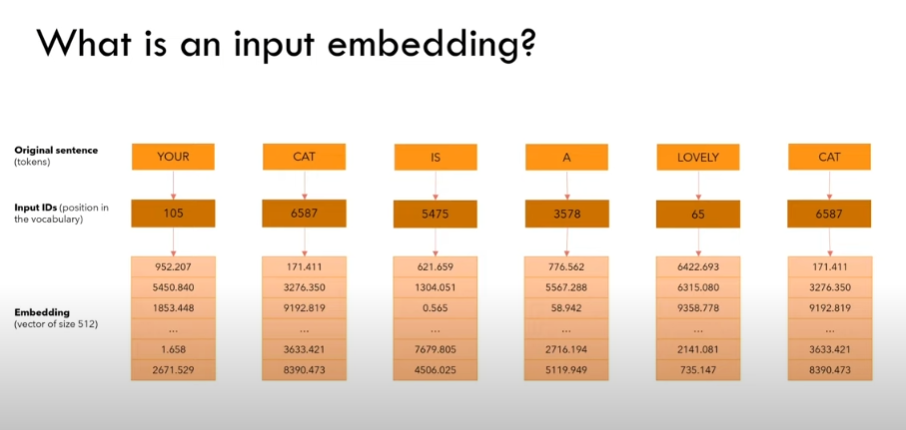

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """
        Initialize the InputEmbedding module.

        Args:
            embed_dim (int): The dimensionality of the input embedding.
            vocab_size (int): The size of the vocabulary.

        """
        super().__init__()
        # Store the dimensionality and vocabulary size
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # Create an embedding layer that maps the vocabulary to a embed_dim-dimensional space
        # The embedding layer should have shape (vocab_size, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        """
        Perform the forward pass of the InputEmbedding module.

        Args:
            x (tensor): The input tensor.

        Returns:
            tensor: The embedded input tensor after scaling it by the square root of the dimensionality.

        """
        # Embed the input tensor using the embedding layer
        # Shape: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded_input = self.embedding(x)
        # Scale the embedded input tensor by the square root of the dimensionality
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        scaled_embedded_input = embedded_input * torch.sqrt(torch.tensor(self.embed_dim))
        return scaled_embedded_input


The InputEmbedding class is not a tokenizer but an embedding layer that is part of a neural network model.
The layer is trainable, which means that the embeddings are learned during the training process.


Tokenizers, on the other hand, are responsible for breaking down text into tokens or subword units, and they are often used before the input is passed to an embedding layer like the one implemented in this class. Tokenizers handle tasks such as splitting text into words or subwords, handling special tokens, and encoding text into numerical inputs that the model can process.

If we look at the image above the Input embedding handles going from a sequence of tokens to a sequence of vectors. A tokenizer handles going from a sequence of characters to a sequence of tokens.

Shape of the input embedding is (batch_size, seq_len, embed_dim)

Let's imageine we wanted to embed the following sentence:

Assuming:

embed_dim = 3
seq_len = 4

"I really love transformers" -> ["I", "really", "love", "transformers"] -> [1, 2, 3, 4] -> [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [0.10, 0.11, 0.12]]

Size: (1, 4, 3)


In [3]:
# Create an instance of the InputEmbedding class
embed_dim = 300  # Example value for the dimensionality
vocab_size = 10000  # Example value for the vocabulary size
input_embedding = InputEmbedding(embed_dim, vocab_size)

# Define your input tensor
input_sequence = torch.rand(2, 10).long()

# Pass the input tensor through the InputEmbedding
embedded_sequence = input_embedding(input_sequence)

# Print the shape of the output tensor
print(embedded_sequence)
# Shape: (5, 300)
print(f"Output tensor shape: {embedded_sequence.shape}")

tensor([[[ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         ...,
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935]],

        [[ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         ...,
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935],
         [ 33.7527, -21.9490,  11.8556,  ...,  52.4907,  32.9603,  22.6935]]],
       grad_fn=<MulBackward0>)
Output tensor

# Next we build the Positional Encoding

The PositionalEncoding class implements a positional encoding layer that adds positional information to the input embeddings.

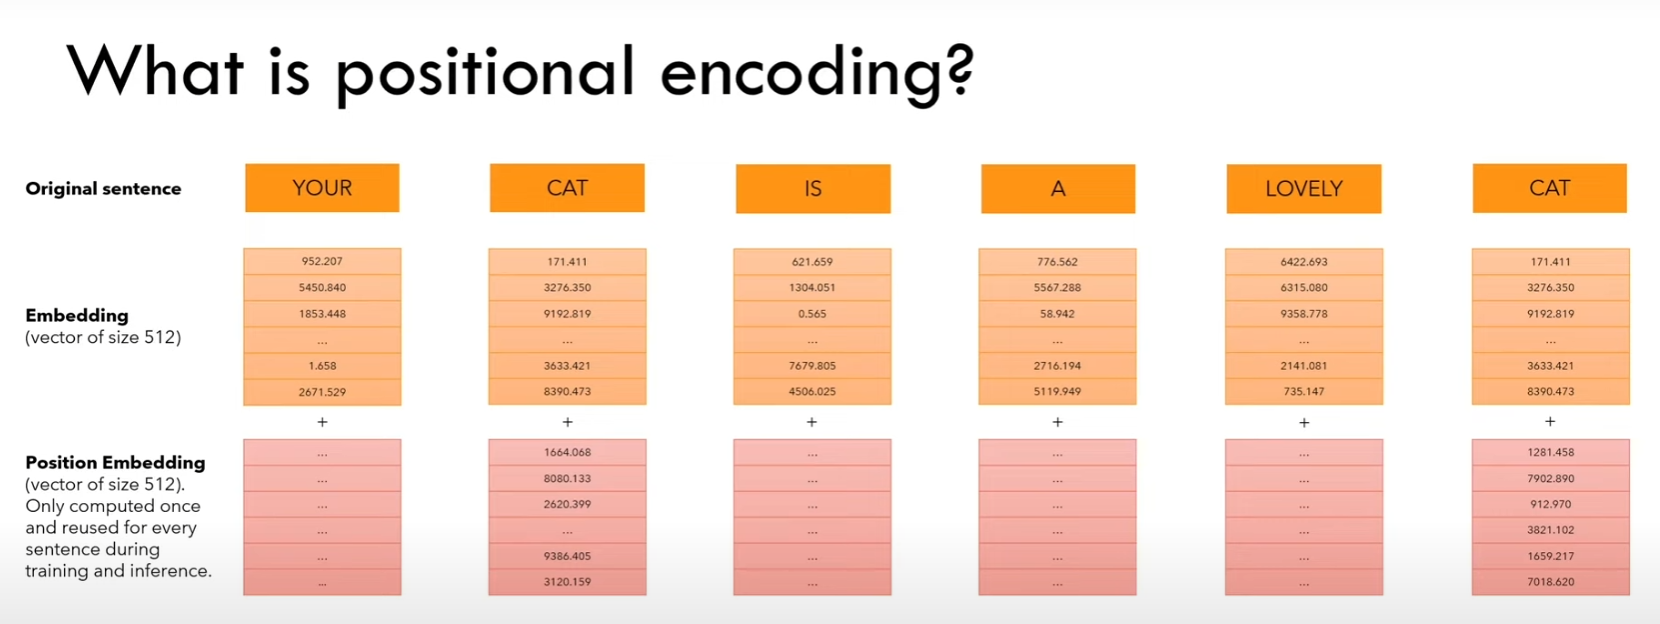

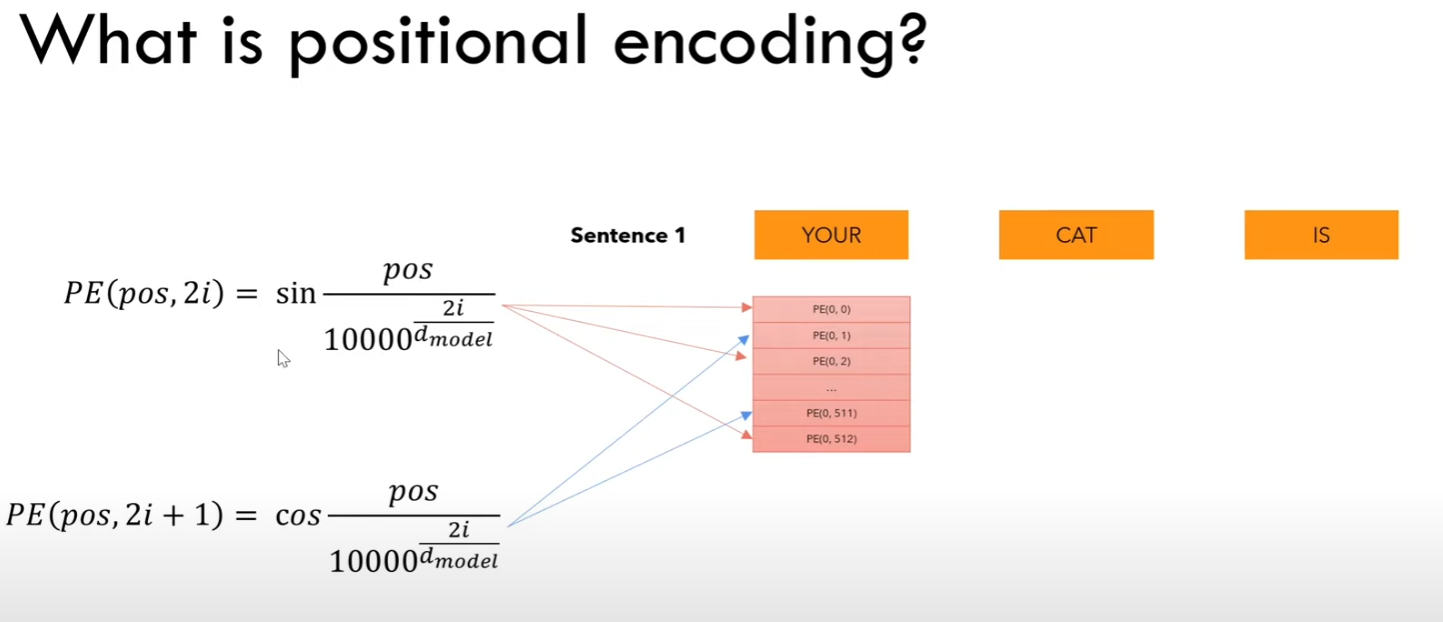

The requires_grad_(False) call sets the requires_grad attribute of the tensor slice to False, indicating that this part of the tensor won't require gradient computation during backpropagation. This effectively detaches the computation graph for this portion of the tensor, making it a leaf tensor that doesn't participate in further gradient computation.

In the second version: The clone() method creates a copy of the positional encoding matrix, and the detach() method further detaches the copy from the computation graph, similar to setting requires_grad to False. This way, the computation of the positional encoding matrix doesn't affect the gradient computation of the input tensor x.

While both versions aim to prevent the positional encoding from being considered in the gradient computation, the first version uses requires_grad_(False) directly on the tensor slice, whereas the second version creates a detached copy of the positional encoding matrix.

Overall, both versions achieve the goal of excluding the positional encoding matrix from the gradient computation, ensuring that the gradients aren't propagated through the positional encoding matrix during backpropagation. However, the first version is more direct in its approach, while the second version is more explicit in creating a detached copy of the positional encoding matrix before adding it to the input tensor.

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int = 512, max_seq_len: int = 100, dropout: float = 0.1,):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)
        # Precompute the positional encoding matrix
        self.positional_encoding = self._precompute_positional_encoding(max_seq_len, embed_dim)

    def _precompute_positional_encoding(self, max_seq_len, embed_dim):
        """Precompute the positional encoding matrix."""
        with torch.no_grad():
            # Create a positional encoding matrix of shape (max_seq_len, embed_dim)
            positional_encoding = torch.zeros(max_seq_len, embed_dim)
            # Create a tensor 'pos' with values [0, 1, 2, ..., max_seq_len - 1] (max_seq_len, 1)
            position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
            # Compute the positional encoding matrix
            division_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
            positional_encoding[:, 0::2] = torch.sin(position * division_term)
            positional_encoding[:, 1::2] = torch.cos(position * division_term)
            # Shape (max_seq_len, embed_dim) -> (1, max_seq_len, embed_dim)
            positional_encoding = positional_encoding.unsqueeze(0)

        return positional_encoding

    def forward(self, x):
        """Perform the forward pass of the PositionalEncoding module."""
        # Add the positional encoding matrix to the input tensor
        x = x + self.positional_encoding[:, : x.size(1)].to(x.device)
        # Apply dropout to the input tensor
        x = self.dropout(x)
        return x

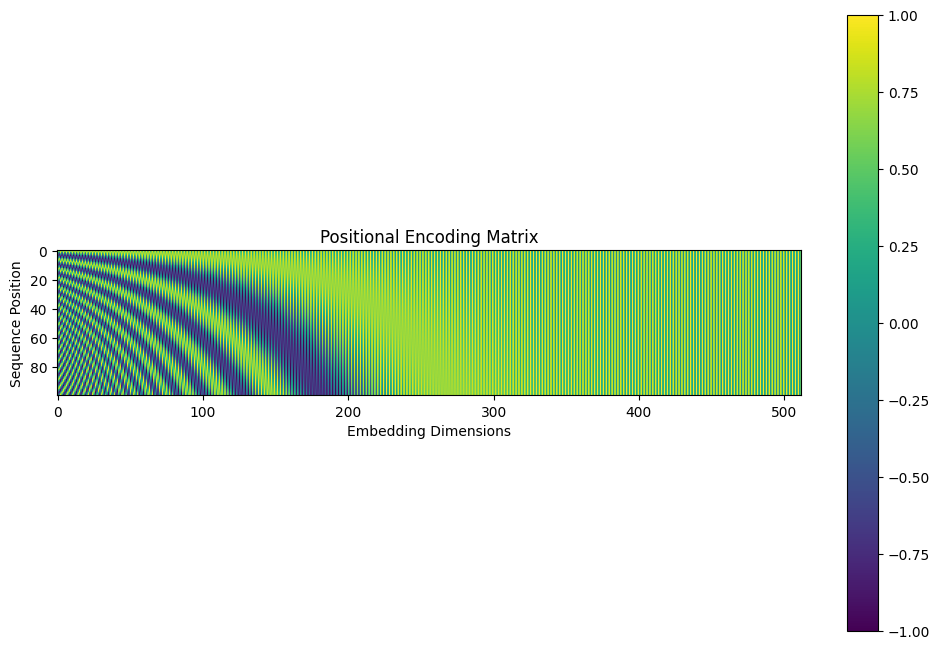

In [5]:
# Create an instance of the PositionalEncoding class and plot the positional encoding matrix
# Size (batch_size, max_seq_len, embed_dim) -> (max_seq_len, embed_dim)
# Example: (1, 100, 512) -> (100, 512)
positional_encoding = PositionalEncoding(embed_dim=512, max_seq_len=100)
# Plot the positional encoding matrix
positional_tensor = positional_encoding.positional_encoding.squeeze(0)
plt.figure(figsize=(12, 8))
plt.imshow(positional_tensor)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.colorbar()
plt.title("Positional Encoding Matrix")
plt.show()


# Lets build the Encoder: Starting with layer normalization

Layer Normalization is similar to Batch normalization but instead of normalizing across the batch dimension, layer normalization normalizes across the feature dimension. This can be computed on the fly, at each step, independently for each instance. This means it behaves the same way during training and testing (unlike Batch Normalization).

Purpose:

* LayerNorm normalizes the activations of each layer across feature dimensions independently for each sample in a mini-batch. It aims to stabilize the training process and reduce the impact of the scale of input features.

Normalization Strategy:

* LayerNorm normalizes the activations across the feature dimension independently for each sample in the mini-batch. It calculates the mean and standard deviation of each feature across the feature dimension and normalizes the features using these statistics.

Learnable Parameters:

* LayerNorm does not introduce any learnable parameters. It normalizes the activations based solely on the mean and standard deviation computed across the feature dimension.

Applicability:

* LayerNorm is often used in natural language processing (NLP) tasks, such as sequence modeling and language understanding, where the feature dimensions can vary across samples.

Performance:

* LayerNorm is less sensitive to batch size and performs well even in small batch sizes. It can also be applied in scenarios where the sequence length varies across samples.

### References:
[PyTorch LAYERNORM Documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm)

[Layer Normalization Paper](https://arxiv.org/abs/1607.06450)

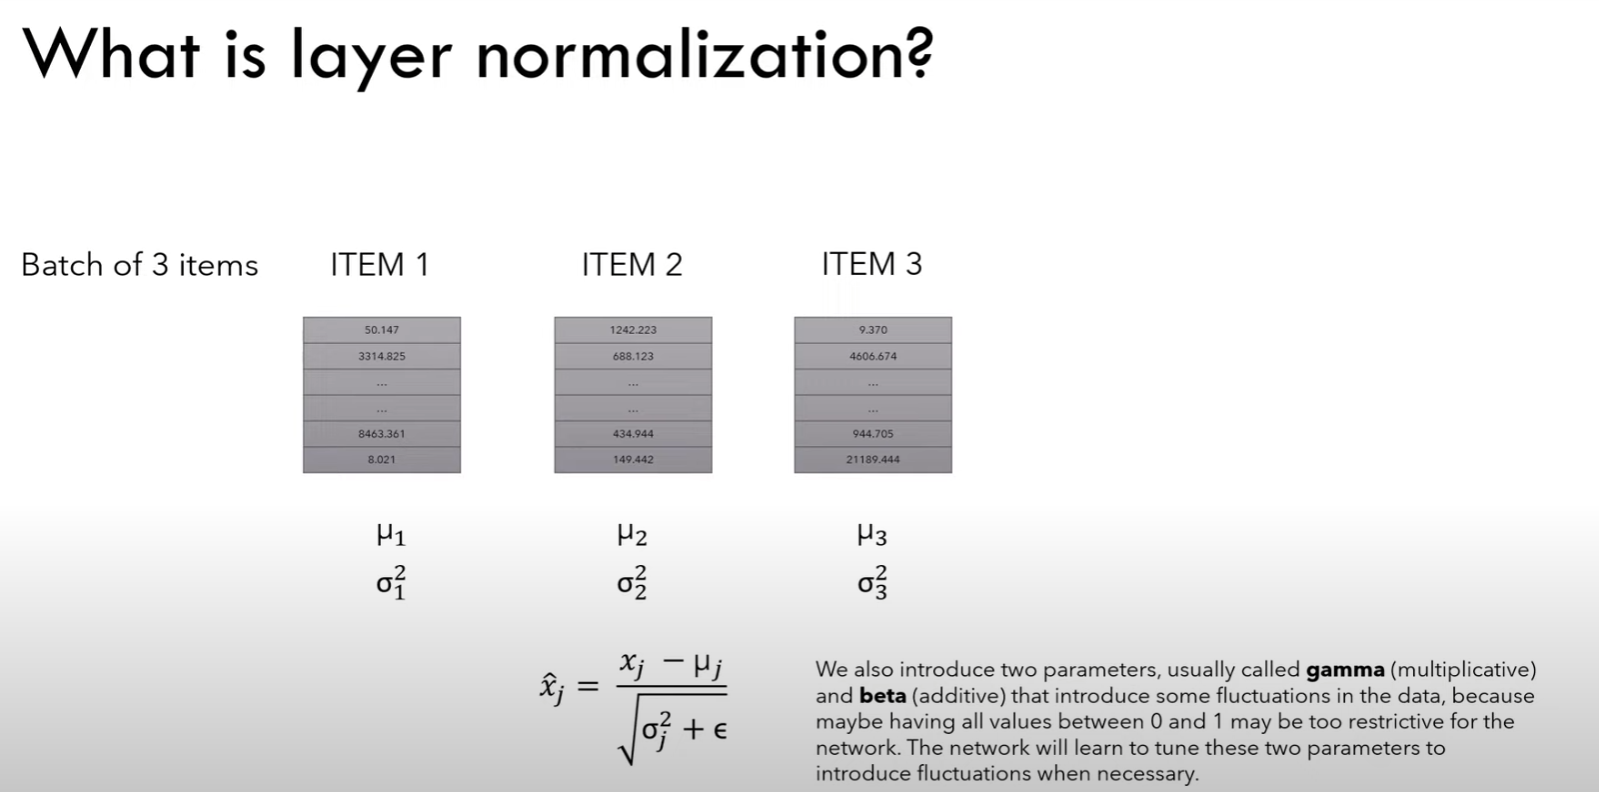

In [6]:
class LayerNormalization(nn.Module):
    def __init__(self, embed_dim: int, eps: float = 1e-6):
        """Initialize the LayerNormalization module."""
        super().__init__()
        self.eps = eps
        # Create two learnable parameters to scale and shift the normalized input
        self.gain = nn.Parameter(torch.Tensor(embed_dim).uniform_())  # Initialize with values sampled from a uniform distribution
        self.bias = nn.Parameter(torch.Tensor(embed_dim).normal_())    # Initialize with values sampled from a normal distribution


    def forward(self, x):
        """Perform the forward pass of the LayerNormalization module."""
        # Compute the mean and standard deviation of the input tensor
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # Zero center by subtracting the mean from the input tensor
        # Normalize scale by dividing by the standard deviation and add epsilon for numerical stability
        # Scale and shift the normalized input using the learnable parameters
        return (x - mean) / (std + self.eps) * self.gain + self.bias

# Building Feed Forward Layer

In [7]:
class FeedForwardBlock(nn.Module):
    def __init__(self, embed_dim: int, intermediate_size: int, dropout: float = 0.1):
        """Initialize the FeedForwardBlock module.
        embed_dim is the hidden size of the transformer model functions as input and output size of the FeedForwardBlock
        intermediate_size is the hidden size of the intermediate layer in the FeedForwardBlock
        dropout is the dropout probability
        """
        super().__init__()
        # embed_dim is the dimensionality of the input and output of the FeedForwardBlock
        # intermediate_size is the dimensionality of the intermediate layer in the FeedForwardBlock
        self.fc1 = nn.Linear(embed_dim, intermediate_size) # W1 and B1 in the formula
        self.fc2 = nn.Linear(intermediate_size, embed_dim) # W2 and B2 in the formula
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Perform the forward pass of the FeedForwardBlock module."""
        # (Batch, Seq_len, embed_dim) -> (Batch, Seq_len, intermediate_size) -> (Batch, Seq_len, embed_dim)
        x_intermediate = self.dropout(F.relu(self.fc1(x)))
        x_output = self.fc2(x_intermediate)
        return x_output

# Building Multi Head Attention Layer

Generally what the multi head attention layer does is:
* Create 3 copies of the input tensor representing the query, key, and value. Shape (batch_size, seq_len, embed_dim).
* Multiply the query, key, and value tensors with their respective weight matrices to obtain the query, key, and value projections. Shape (batch_size, seq_len, embed_dim).
* Split the query, key, and value projections into, h, number of heads. Shape (batch_size, num_heads, seq_len, embed_dim / num_heads).
  * Each split is done along the embedding dimension, not the sequence dimension.
  * This allows the attention head to access the full sentence, though only a portion of the embedding of each word. (word embeddings)
  * The split is done to allow each head to attend to a different part of the sequence.
* Apply the scaled dot product attention on each head. Shape (batch_size, num_heads, seq_len, embed_dim / num_heads).
* Concatenate the attention head outputs. Shape (batch_size, seq_len, embed_dim).
* Multiply the concatenated tensor with the output weight matrix to obtain the multi-head attention output. Shape (batch_size, seq_len, embed_dim).

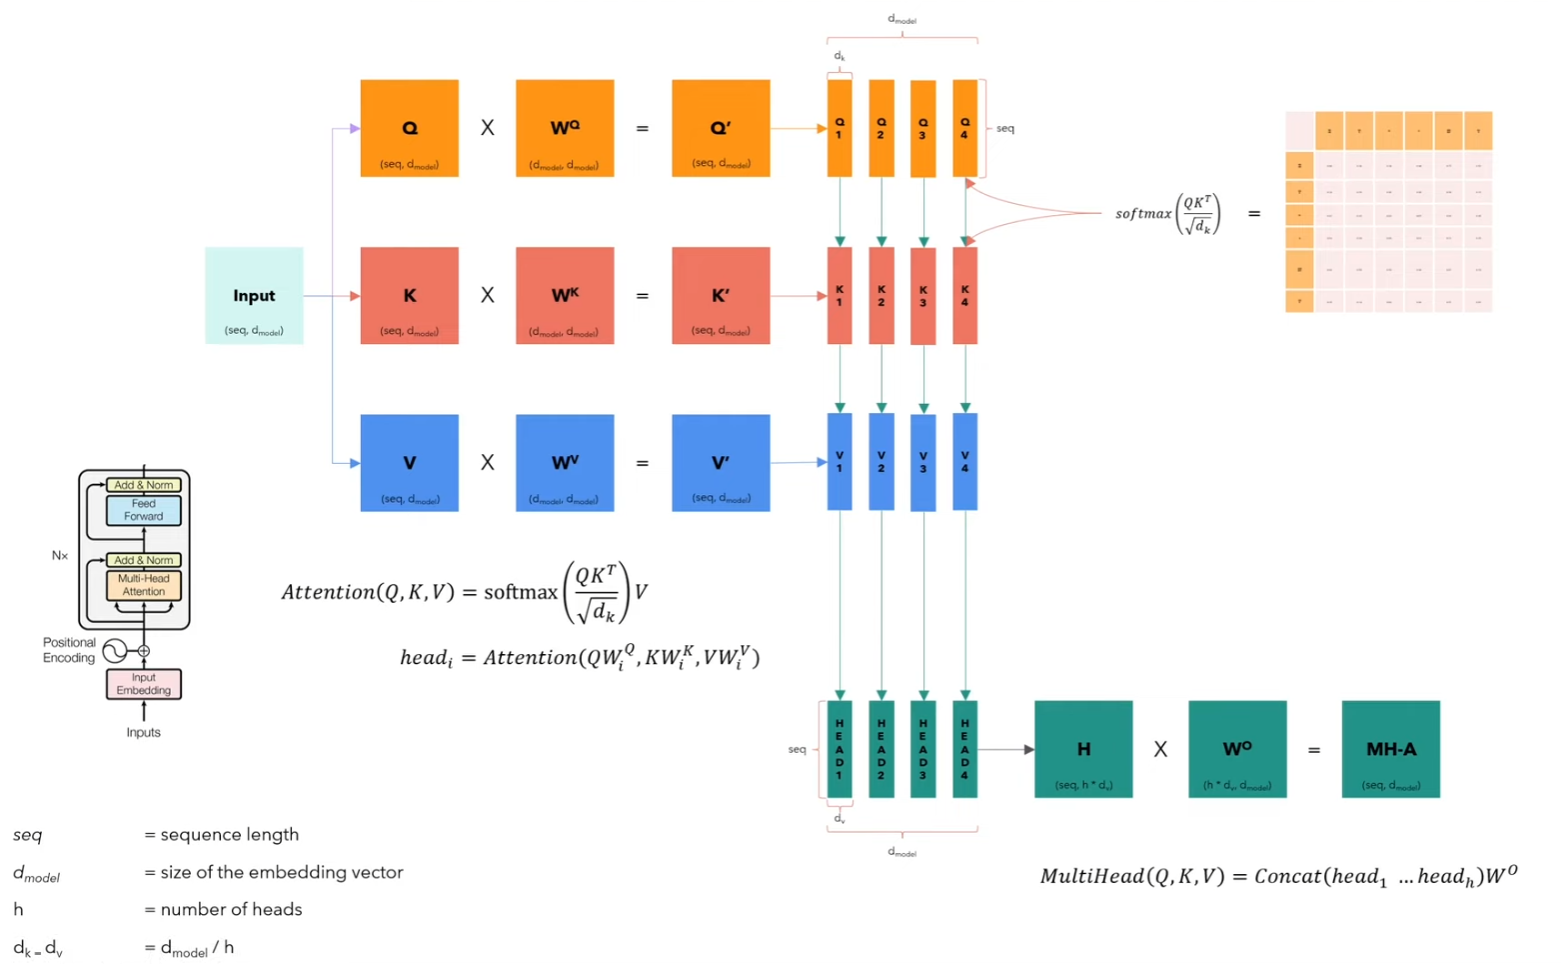

What do Query, Key, and Value mean?
* Query: The word for which we are calculating the attention.
* Key: The word which we are comparing the query to.
* Value: The word which we are going to output.

In [8]:
def generate_square_subsequent_mask(size: int, device: torch.device = "cpu"):
    """Generate a square mask for the sequence."""
    mask = torch.tril(torch.ones(size, size, dtype=torch.bool, device=device), diagonal=0)
    # Turn boolean mask into float mask
    mask = mask.long()
    return mask.unsqueeze(0)  # Add batch dimension

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int = 512, num_heads: int = 8, attn_dropout: float = 0.1, ff_dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0, "invalid heads and embedding dimension configuration"
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(ff_dropout)
    
    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, mask=None,):
        batch_size, seq_len, _ = q.size()
        # Apply linear transformations to the input tensor
        # Take input tensor and apply linear transformation,
        # then split the tensor into num_heads and head_dim
        # transpose the tensor into correct order
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, num_heads, head_dim) ->
        # (batch_size, seq_len, num_heads, head_dim) -> (batch_size, num_heads, seq_len, head_dim)
        q = self.query(q).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        k = self.key(k).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        v = self.value(v).view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        # Compute attention scores using Einsum
        # b: batch size, h: num_heads, i: seq_len, j: seq_len, d: head_dim
        # Multiply query and key tensors element-wise and sum along the shared dimension (head_dim)
        # Divide by the square root of the dimension of the query/key vectors
        # Equivalent to: attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
        # Shape: (batch_size, num_heads, seq_len, head_dim) * (batch_size, num_heads, seq_len, head_dim)
        # -> (batch_size, num_heads, seq_len, seq_len)
        attention = torch.einsum('bhid,bhjd->bhij', q, k) / math.sqrt(q.size(-1))
        
        # Apply mask if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        
        # Apply softmax and dropout
        # Shape: (batch_size, num_heads, seq_len, seq_len) -> (batch_size, num_heads, seq_len, head_dim)
        attention = self.attn_dropout(F.softmax(attention, dim=-1))
        
        # Compute the weighted sum of values using attention scores
        # Equivalent to: torch.matmul(attention, v)
        # Shape: (batch_size, num_heads, seq_len, seq_len) * (batch_size, num_heads, seq_len, head_dim)
        # -> (batch_size, num_heads, seq_len, head_dim)
        y = torch.einsum('bhij,bhjd->bhid', attention, v)

        # Merge the num_heads and head_dim back to the embed_dim
        # Transpose sequence length and num_heads
        # Flatten out the full tensor
        # Reshape based on batch size, sequence length and embed_dim
        # Shape: (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # -> (batch_size, seq_len, num_heads * head_dim)
        # -> (batch_size, seq_len, embed_dim)
        y = y.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Apply linear transformation and dropout
        # Shape: (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        return self.proj_dropout(self.proj(y))


In [10]:
multi_head_attention = MultiHeadAttention(embed_dim=512, num_heads=8, attn_dropout=0.1, ff_dropout=0.1, max_len=512)

# Size (batch_size, seq_len, embed_dim)
sample_input = torch.rand(1, 10, 512)

# Pass the input tensor through the MultiHeadAttention
# Notice the the query, key, and value inputs are the same
# Shape: (1, 10, 512) -> (1, 10, 512)
output = multi_head_attention(sample_input, sample_input, sample_input)
output.shape

torch.Size([1, 10, 512])

# Residual Connection

In [11]:
class ResidualConnection(nn.Module):
    def __init__(self, embed_dim, dropout: float = 0.1):
        """Initialize the ResidualConnection module."""
        super().__init__()
        self.layer_norm = LayerNormalization(embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Perform the forward pass of the ResidualConnection module."""
        # Apply sublayer (e.g., feedforward block)
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        sublayer_output = sublayer(x)
        # Apply layer normalization
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        normalized_x = self.layer_norm(x)
        # Add residual connection
        # (batch_size, seq_len, embed_dim) + (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)
        residual_output = normalized_x + sublayer_output
        # Apply dropout to the sum
        return self.dropout(residual_output)

In [12]:
# Create an instance of the ResidualConnection class
batch_size = 1
seq_len = 10
embed_dim = 512

# Size (batch_size, seq_len, embed_dim)
sample_input = torch.rand(batch_size, seq_len, embed_dim)
multi_head_attention = MultiHeadAttention(
    embed_dim=embed_dim, num_heads=8, attn_dropout=0.1, ff_dropout=0.1, max_len=512,
    )

# Pass the input tensor through the MultiHeadAttention
# Notice the the query, key, and value inputs are the same
# Shape: (1, 10, 512) -> (1, 10, 512)
output = multi_head_attention(sample_input, sample_input, sample_input)

# Create an instance of the ResidualConnection class
residual_connection = ResidualConnection(embed_dim=embed_dim, dropout=0.1)
output = residual_connection(sample_input, lambda x: multi_head_attention(x, x, x))
output.shape

torch.Size([1, 10, 512])

# Projection Head

In [13]:
class ProjectionHead(nn.Module):
    def __init__(self, embed_dim: int, vocab_size: int):
        """Initialize the ProjectionHead module."""
        super().__init__()
        self.fc = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        """Perform the forward pass of the ProjectionHead module."""
        # Apply linear transformation to the input tensor
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, vocab_size)
        return self.fc(x)

# Building Encoder Block

In [14]:
class EncoderBlock(nn.Module):
    def __init__(
        self, 
        embed_dim: int = 512, 
        num_heads: int = 8, 
        ff_dim: int = 2048, 
        attn_dropout: float = 0.1, 
        ff_dropout: float = 0.1, 
        max_len: int = 512,
    ):
        super().__init__()
        # Initialize multi-head self-attention mechanism
        self.MultiHeadAttention = MultiHeadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            attn_dropout=attn_dropout, 
            ff_dropout=ff_dropout,
            max_len=max_len,
            )
        # Initialize feed-forward block
        self.feed_forward = FeedForwardBlock(
            embed_dim=embed_dim, 
            intermediate_size=ff_dim, 
            dropout=ff_dropout,
            )
        # Initialize residual connections
        self.residual_connection1 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)
        self.residual_connection2 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)

    def forward(self, x, attention_mask=None):
        # Apply self-attention mechanism with residual connection
        x_with_attention = self.residual_connection1(x, lambda x: self.MultiHeadAttention(x, x, x, mask=attention_mask))
        # Apply feed-forward block with residual connection
        x_with_ff = self.residual_connection2(x_with_attention, self.feed_forward)
        return x_with_ff

In [15]:
# Create an instance of the EncoderBlock class
# Size (batch_size, seq_len, embed_dim)
sample_input = torch.rand(1, 10, 512)
encoder = EncoderBlock(embed_dim=512, num_heads=8, ff_dim=2048, attn_dropout=0.1, ff_dropout=0.1)

# Pass the input tensor through the EncoderBlock
# Shape: (1, 10, 512) -> (1, 10, 512)
output = encoder(sample_input, attention_mask=None)
print(output.shape)

torch.Size([1, 10, 512])


# Building the Encoder

In [16]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim:int = 512,
        vocab_size:int = 10000, 
        max_seq_len:int = 100,
        attn_dropout:float = 0.1,
        ff_dropout:float = 0.1,
        n_blocks:int = 6,
        num_heads:int = 8,
        ff_dim:int = 2048,
    ):
        """Initialize the Encoder module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.embedding = InputEmbedding(embed_dim=embed_dim, vocab_size=vocab_size)
        self.positional_encoding = PositionalEncoding(
            embed_dim=embed_dim, 
            max_seq_len=max_seq_len, 
            dropout=ff_dropout,
        )
        self.blocks = nn.ModuleList([
            EncoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                attn_dropout=attn_dropout,
                ff_dropout=ff_dropout,
            ) for _ in range(n_blocks)
        ])


    def forward(self, input_ids: torch.Tensor, src_mask: torch.Tensor = None):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        for block in self.blocks:
            x = block(x, src_mask)
        return x

In [17]:
embed_dim = 512
vocab_size = 10000
max_seq_len = 100
n_blocks = 6
num_heads = 8
ff_dim = 2048

# Create an instance of the Encoder class
encoder = Encoder(
    embed_dim=embed_dim, 
    vocab_size=vocab_size, 
    max_seq_len=max_seq_len,
    n_blocks=n_blocks, 
    num_heads=num_heads, 
    ff_dim=ff_dim,
)

# Define your input tensor
sample_input = torch.rand(2, 10).long()
mask = generate_square_subsequent_mask(10)

# Pass the input tensor through the Encoder
output = encoder(sample_input, src_mask=mask)

output.shape

torch.Size([2, 10, 512])

# Building the Decoder Block

In [18]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        embed_dim:int = 512,
        num_heads:int = 8,
        ff_dim:int = 2048,
        attn_dropout:float = 0.1,
        ff_dropout:float = 0.1,
        max_len: int = 512,
    ):
        """Initialize the DecoderBlock module."""
        super().__init__()
        # Initialize multi-head self-attention mechanism
        self.MultiHeadAttention = MultiHeadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            attn_dropout=attn_dropout, 
            ff_dropout=ff_dropout,
            max_len=max_len,
            )
        # Initialize multi-head cross-attention mechanism
        self.MultiHeadCrossAttention = MultiHeadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads, 
            attn_dropout=attn_dropout, 
            ff_dropout=ff_dropout,
            max_len=max_len,
            )
        # Initialize feed-forward block
        self.feed_forward = FeedForwardBlock(
            embed_dim=embed_dim, 
            intermediate_size=ff_dim, 
            dropout=ff_dropout,
            )
        # Initialize residual connections
        self.residual_connection1 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)
        self.residual_connection2 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)
        self.residual_connection3 = ResidualConnection(embed_dim=embed_dim, dropout=ff_dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Apply self-attention mechanism with residual connection
        x_with_self_attention = self.residual_connection1(
            x,
            lambda x: self.MultiHeadAttention(x, x, x, mask=tgt_mask,
            ))

        # Apply cross-attention mechanism with residual connection
        x_with_cross_attention = self.residual_connection2(
            x_with_self_attention,
            lambda x: self.MultiHeadCrossAttention(
                encoder_output, encoder_output, x_with_self_attention, mask=src_mask
            )
        )

        # Apply feed-forward block with residual connection
        x_with_ff = self.residual_connection3(x_with_cross_attention, self.feed_forward)
        return x_with_ff

In [19]:
embed_dim = 512
max_seq_len = 100
n_blocks = 6
num_heads = 8
ff_dim = 2048

# Create an instance of the DecoderBlock class
decoder_block = DecoderBlock(
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    ff_dim=ff_dim,
    attn_dropout=0.1, 
    ff_dropout=0.1,
)

# Define your input tensor
sample_input = torch.rand(2, 10, 512)
encoder_output = torch.rand(2, 10, 512)

# Pass the input tensor through the DecoderBlock
output = decoder_block(sample_input, encoder_output=encoder_output, src_mask=None, tgt_mask=None)

output.shape

torch.Size([2, 10, 512])

# Building the Decoder

In [20]:
class Decoder(nn.Module):
    def __init__(
        self,
        embed_dim:int = 512,
        vocab_size:int = 10000, 
        max_seq_len:int = 100,
        attn_dropout:float = 0.1,
        ff_dropout:float = 0.1,
        n_blocks:int = 6,
        num_heads:int = 8,
        ff_dim:int = 2048,
    ):
        """Initialize the Encoder module."""
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.embedding = InputEmbedding(embed_dim=embed_dim, vocab_size=vocab_size)
        self.positional_encoding = PositionalEncoding(
            embed_dim=embed_dim, 
            max_seq_len=max_seq_len, 
            dropout=ff_dropout,
        )
        self.blocks = nn.ModuleList([
            DecoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                attn_dropout=attn_dropout,
                ff_dropout=ff_dropout,
            ) for _ in range(n_blocks)
        ])


    def forward(self, input_ids: torch.Tensor, encoder_output: torch.Tensor, src_mask: torch.Tensor = None, tgt_mask: torch.Tensor = None):
        x = self.embedding(input_ids)
        x = self.positional_encoding(x)
        for block in self.blocks:
            x = block(x, encoder_output, src_mask, tgt_mask)
        return x

In [21]:
embed_dim = 512
vocab_size = 10000
max_seq_len = 100
n_blocks = 6
num_heads = 8
ff_dim = 2048

# Create an instance of the Decoder class
decoder = Decoder(
    embed_dim=embed_dim, 
    vocab_size=vocab_size, 
    max_seq_len=max_seq_len,
    n_blocks=n_blocks, 
    num_heads=num_heads, 
    ff_dim=ff_dim,
)

# Define your input tensor
sample_input = torch.rand(2, 10).long()
encoder_output = torch.rand(2, 10, 512)

# Pass the input tensor through the Decoder
output = decoder(sample_input, encoder_output=encoder_output, src_mask=None, tgt_mask=None)

output.shape

torch.Size([2, 10, 512])

# Build Transformer

In [22]:
class Transformer(nn.Module):
    def __init__(
        self,
        embed_dim:int = 512,
        src_vocab_size:int = 10000,
        tgt_vocab_size:int = 10000,
        src_seq_len:int = 100,
        tgt_seq_len:int = 100,
        attn_dropout:float = 0.1,
        ff_dropout:float = 0.1,
        n_blocks:int = 6,
        num_heads:int = 8,
        ff_dim:int = 2048,
    ):
        """Initialize the Transformer module."""
        super().__init__()
        # Initialize encoder
        self.encoder = Encoder(
            embed_dim=embed_dim,
            vocab_size=src_vocab_size,
            max_seq_len=src_seq_len,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout,
            n_blocks=n_blocks,
            num_heads=num_heads,
            ff_dim=ff_dim,
        )
        # Initialize decoder
        self.decoder = Decoder(
            embed_dim=embed_dim,
            vocab_size=tgt_vocab_size,
            max_seq_len=tgt_seq_len,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout,
            n_blocks=n_blocks,
            num_heads=num_heads,
            ff_dim=ff_dim,
        )
        # Initialize projection layer
        self.projection_layer = ProjectionHead(embed_dim, tgt_vocab_size)
    
    def forward(self, src_ids, tgt_ids, src_mask=None, tgt_mask=None):
        encoder_output = self.encoder(src_ids, src_mask)
        decoder_output = self.decoder(tgt_ids, encoder_output, src_mask, tgt_mask)
        output = self.projection_layer(decoder_output)
        return output

In [23]:
model = Transformer(
    embed_dim=512,
    src_vocab_size=10000, 
    tgt_vocab_size=10000, 
    src_seq_len=100, 
    tgt_seq_len=100,
    attn_dropout=0.1,
    ff_dropout=0.1,
    n_blocks=1, # number of encoder and decoder blocks 2*n_layers total layers
    num_heads=8,
    ff_dim=2048, # dimensionality of the feed-forward block
    )

In [24]:
# Define the source and target data
src_input = torch.rand(2, 10).long()
tgt_input = torch.rand(2, 10).long()

# Pass the source and target data through the transformer
# Shape: (batch_size, tgt_seq_len, tgt_vocab_size)
output = model(src_input, tgt_input, src_mask=None, tgt_mask=None)
print(output.shape)

torch.Size([2, 10, 10000])


# What does the output mean?

output is size (batch_size, tgt_seq_len, tgt_vocab_size).

Suppose we have a trained sequence-to-sequence model for English-to-French translation. After providing an English sentence as input to the model, it generates an output tensor of shape (1, 10, 10000), where:

1 indicates the batch size (in this case, just one sentence)
10 represents the maximum length of the output sequence
10000 is the size of the French vocabulary
Each element of this tensor represents the probability of each French word in the vocabulary appearing at a specific position in the translated sentence.

To extract the translated sentence from this tensor, we follow these steps:

1. Probabilistic Selection: At each time step (word position), we examine the probability distribution over the French vocabulary. We might use argmax to select the word with the highest probability at each time step, or employ beam search to consider multiple possibilities.

2. Token-to-Word Conversion: Once we have selected the indices of the most probable words at each time step, we convert these indices into actual French words using a dictionary or lookup table.

3. Concatenation: Finally, we concatenate these words to form the translated sentence.

# Training the Transformer

In [25]:
sample_data_english = [
    "Mary had a little lamb",
    "Its fleece was white as snow",
    "And everywhere that Mary went",
    "The lamb was sure to go",
]

sample_data_spanish = [
    "María tenía un corderito",
    "Su lana era blanca como la nieve",
    "Y a dondequiera que María iba",
    "El corderito seguro que iba",
]

dataset = list(zip(sample_data_english, sample_data_spanish))

In [26]:
class Tokenizer():
    def __init__(self):
        self.str2token = None
        self.token2str = None
        self.special_tokens = {
            "[SOS]": 0,
            "[EOS]": 1,
            "[PAD]": 2,
        }
        self.special_tokens_rev = {v: k for k, v in self.special_tokens.items()}
    
    def fit(self, data: list):
        # Create a vocabulary mapping from tokens to strings
        self.str2token = self.special_tokens
        self.token2str = self.special_tokens_rev
        for sentence in data:
            for token in sentence.split():
                if token not in self.str2token.keys():
                    token_id = len(self.str2token.keys())
                    self.str2token[token] = token_id
                    self.token2str[token_id] = token

    def decode(self, tokens: list):
        # Convert a list of token IDs to a string
        decoded_tokens = []
        for token in tokens:
            if isinstance(token, torch.Tensor):
                token = token.item()  # Convert tensor to int
            decoded_tokens.append(self.token2str[token])
        return " ".join(decoded_tokens)

    def __call__(self, sentence: str, truncation=False, return_tensors='pt'):
        # Convert the input string to a list of token IDs
        token_ids = [self.str2token[token] for token in sentence.split()]
        if return_tensors == 'pt':
            token_ids = torch.tensor(token_ids)
        output = {'input_ids': token_ids}
        return output

In [27]:
en_tokenizer = Tokenizer()
en_tokenizer.fit(sample_data_english)
output = en_tokenizer("Mary had a little lamb")
print(output['input_ids'])
decode = en_tokenizer.decode(output['input_ids'])
print(decode)

tensor([3, 4, 5, 6, 7])
Mary had a little lamb


In [28]:
sp_tokenizer = Tokenizer()
sp_tokenizer.fit(sample_data_spanish)
output = sp_tokenizer("María tenía un corderito")
print(output['input_ids'])
decode = sp_tokenizer.decode(output['input_ids'])
print(decode)

tensor([3, 4, 5, 6])
María tenía un corderito


In [29]:
class MachineTranslationDataset(Dataset):
    def __init__(self, data, src_tokenizer, tgt_tokenizer, max_length=10):
        self.data = data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length
        self.sos_token = self.tgt_tokenizer.special_tokens["[SOS]"]
        self.eos_token = self.tgt_tokenizer.special_tokens["[EOS]"]
        self.pad_token = self.tgt_tokenizer.special_tokens["[PAD]"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # unpack the source and target sentences
        src_text, tgt_text = self.data[idx]
        # tokenize the source and target sentences
        src_tokenized = self.src_tokenizer(src_text, return_tensors='pt')['input_ids']
        tgt_tokenized = self.tgt_tokenizer(tgt_text, return_tensors='pt')['input_ids']
        # truncate or pad the source sentence
        if src_tokenized.shape[0] > self.max_length:
            src_input = src_tokenized[:self.max_length]
        else:
            src_input = F.pad(src_tokenized, (0, self.max_length - src_tokenized.shape[0]), value=self.pad_token)
        # truncate or pad the target sentence
        if tgt_tokenized.shape[0] > self.max_length:
            tgt_tokenized = tgt_tokenized[:self.max_length]
        else:
            tgt_tokenized = F.pad(tgt_tokenized, (0, self.max_length - tgt_tokenized.shape[0]), value=self.pad_token)

        # process the target input
        tgt_input = tgt_tokenized.new(tgt_tokenized.shape)
        tgt_input[0] = self.sos_token
        tgt_input[1:] = tgt_tokenized[:-1]

        # pad or truncate the target input
        if tgt_input.shape[0] > self.max_length:
            tgt_input = tgt_input[:self.max_length]
        else:
            tgt_input = F.pad(tgt_input, (0, self.max_length - tgt_input.shape[0]), value=self.pad_token)

        return src_input, tgt_input, tgt_tokenized

In [30]:
train_dataset = MachineTranslationDataset(dataset, en_tokenizer, sp_tokenizer, max_length=10)
data = train_dataset[0]
data

(tensor([3, 4, 5, 6, 7, 2, 2, 2, 2, 2]),
 tensor([0, 3, 4, 5, 6, 2, 2, 2, 2, 2]),
 tensor([3, 4, 5, 6, 2, 2, 2, 2, 2, 2]))

In [ ]:
src_vocab_size = len(en_tokenizer.str2token)
tgt_vocab_size = len(sp_tokenizer.str2token)
print(f"Source Vocabulary Size: {src_vocab_size}")
print(f"Target Vocabulary Size: {tgt_vocab_size}")

In [ ]:
model = Transformer(
    embed_dim=512,
    src_vocab_size=22, 
    tgt_vocab_size=21, 
    src_seq_len=10, 
    tgt_seq_len=10,
    attn_dropout=0.1,
    ff_dropout=0.1,
    n_blocks=1, # number of encoder and decoder blocks 2*n_layers total layers
    num_heads=8,
    ff_dim=2048, # dimensionality of the feed-forward block
    )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-5
batch_size = 2
num_epochs = 5

In [ ]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        # Unpack input and label from the batch and send them to the device
        src_input, tgt_input, tgt_target = batch

        # Send the input and target to the device
        src_input = src_input.to(device)
        tgt_input = tgt_input.to(device)
        tgt_target = tgt_target.to(device)

        # Generate the causal mask
        # Shape: (batch_size, seq_len, seq_len) 
        src_mask = generate_square_subsequent_mask(src_input.size(1), device=device)
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1), device=device)

        # Forward pass
        logits = model(src_input, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)
        
        # Flatten the logits and labels for computing the loss
        logits_flat = logits.view(-1, logits.size(-1))

        # Compute the loss
        loss = criterion(logits_flat, tgt_target.view(-1))

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# Inference with the Transformer

In [ ]:
model_inference = Transformer(
    embed_dim=512,
    src_vocab_size=22, 
    tgt_vocab_size=21, 
    src_seq_len=10, 
    tgt_seq_len=10,
    attn_dropout=0.1,
    ff_dropout=0.1,
    n_blocks=1, # number of encoder and decoder blocks 2*n_layers total layers
    num_heads=8,
    ff_dim=2048, # dimensionality of the feed-forward block
    )

In [ ]:
def translate_sentence(sentence, model, src_tokenizer, tgt_tokenizer, device, max_length=10):
    # extract the special tokens
    src_pad_token = src_tokenizer.special_tokens["[PAD]"]
    tgt_sos_token = tgt_tokenizer.special_tokens["[SOS]"]
    tgt_end_token_id = tgt_tokenizer.special_tokens["[EOS]"]

    # make target input tensor
    tgt_input = torch.tensor([[tgt_sos_token]]).to(device)

    # tokenize and prepare the source sentence
    src_input = src_tokenizer(sentence, return_tensors='pt')['input_ids']
    
    # pad or truncate the source sentence
    if src_input.shape[0] > max_length:
        src_input = src_input[:max_length]
    else:
        src_input = F.pad(src_input, (0, max_length - src_input.shape[0]), value=src_pad_token)
    src_input = src_input.unsqueeze(0).to(device)

    # create a mask for the source sentence
    src_mask = (src_input != src_pad_token).long()
    src_mask = src_mask.unsqueeze(0).to(device)

    # move model to device
    model.to(device)
    model.eval()
    generated_ids = []
    for _ in range(max_length):
        output = model(src_input, src_input, src_mask=src_mask, tgt_mask=None)
        next_token_logits = output[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1)
        tgt_input = torch.cat([tgt_input, next_token_id.unsqueeze(-1)], dim=-1)
        generated_ids.append(next_token_id.item())
        if next_token_id == tgt_end_token_id:
            break
    gnerated_text = tgt_tokenizer.decode(generated_ids)
    return gnerated_text

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
translate_sentence(
    "Mary had a little lamb",
    model_inference,
    en_tokenizer,
    sp_tokenizer,
    device,
    max_length=10,
)